In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!unzip -q "/content/gdrive/My Drive/hw5.zip"

Mounted at /content/gdrive


In [3]:
!unzip -q "/content/gdrive/My Drive/hw5_code.zip"

In [62]:
# You may want to install "gprof2dot"
import io
from collections import Counter
import numpy as np
import scipy.io
import sklearn.model_selection
import sklearn.tree
from numpy import genfromtxt
from scipy import stats
from sklearn.base import BaseEstimator, ClassifierMixin
import pydot
import random
random.seed(0)
np.random.seed(0)
eps = 1e-5  # a small number
class DecisionTree:
    def __init__(self, max_depth=3, feature_labels=None):
        self.max_depth = max_depth
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes

    @staticmethod
    def information_gain(X, y, thresh):
        # TODO: implement information gain function
        #here we make a helper function in order to properly conduct
        #the information gain function
        def helper(y):
            totfeats = len(y)
            feat_unique = np.unique(y, return_counts=True)
            tot = 0
            for feat in feat_unique[1]:
                freq = feat/totfeats
                #formulaically w subtract the xlog(x) value for the feat freqs
                tot -= freq * np.log2(freq)
            return tot
        arrelt = np.where(X < thresh)[0]
        eltofy = y[arrelt]
        invarrelt = np.where(X >= thresh)[0]
        eltofy2 = y[invarrelt]
        lessinfo = helper(eltofy)
        greaterinfo = helper(eltofy2)
        #here we get all the values and just use our formula to get the info
        a = (len(eltofy) * lessinfo + len(eltofy2) * greaterinfo)
        b = (len(eltofy) + len(eltofy2))
        return -1 * a / b

    @staticmethod
    def gini_impurity(X, y, thresh):
        # TODO: implement gini impurity function
        pass
        #we can do this problem without actually implementing the gini impurity function

    def split(self, X, y, idx, thresh):
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def split_test(self, X, idx, thresh):
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1

    def fit(self, X, y):
        if self.max_depth > 0:
            # compute entropy gain for all single-dimension splits,
            # thresholding with a linear interpolation of 10 values
            gains = []
            # The following logic prevents thresholding on exactly the minimum
            # or maximum values, which may not lead to any meaningful node
            # splits.
            thresh = np.array([
                np.linspace(np.min(X[:, i]) + eps, np.max(X[:, i]) - eps, num=10)
                for i in range(X.shape[1])
            ])
            for i in range(X.shape[1]):
                gains.append([self.information_gain(X[:, i], y, t) for t in thresh[i, :]])

            gains = np.nan_to_num(np.array(gains))
            self.split_idx, thresh_idx = np.unravel_index(np.argmax(gains), gains.shape)
            self.thresh = thresh[self.split_idx, thresh_idx]
            X0, y0, X1, y1 = self.split(X, y, idx=self.split_idx, thresh=self.thresh)
            if X0.size > 0 and X1.size > 0:
                self.left = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.left.fit(X0, y0)
                self.right = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.right.fit(X1, y1)
            else:
                self.max_depth = 0
                self.data, self.labels = X, y
                self.pred = stats.mode(y).mode[0]
        else:
            self.data, self.labels = X, y
            self.pred = stats.mode(y).mode[0]
        return self

    #here we define a new fit function which we will explicitly using instead of
    #the prior fit function
    def baggedfit(self, X, y, r):
        if self.max_depth > 0:
            # compute entropy gain for all single-dimension splits,
            # thresholding with a linear interpolation of 10 values
            gains = []
            # The following logic prevents thresholding on exactly the minimum
            # or maximum values, which may not lead to any meaningful node
            # splits.

            #here we want to define our space set for the X data set and then we
            #want to get the random vals to effectively generate this random fit
            #this will help us create an accurate function and if our value isnt
            #in our rfv then we will append -100s to the gains similar the the 
            #method discussed earlier
            rows = np.arange(X.shape[1])
            randforestvals = np.random.choice(rows, r, replace = False)
            thresh = np.array([
                np.linspace(np.min(X[:, i]) + eps, np.max(X[:, i]) - eps, num=10)
                for i in range(X.shape[1])
            ])
            for i in range(X.shape[1]):
                if i in randforestvals:
                    gains.append([self.information_gain(X[:, i], y, t) for t in thresh[i, :]])
                else:
                    gains.append([-100 for t in thresh[i, :]])

            gains = np.nan_to_num(np.array(gains))
            self.split_idx, thresh_idx = np.unravel_index(np.argmax(gains), gains.shape)
            self.thresh = thresh[self.split_idx, thresh_idx]
            X0, y0, X1, y1 = self.split(X, y, idx=self.split_idx, thresh=self.thresh)
            if X0.size > 0 and X1.size > 0:
              #here we also want to use baggedfit instead of our regular fit to 
              #continue our pattern
                self.left = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.left.baggedfit(X0, y0, r)
                self.right = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.right.baggedfit(X1, y1, r)
            else:
                self.max_depth = 0
                self.data, self.labels = X, y
                self.pred = stats.mode(y).mode[0]
        else:
            self.data, self.labels = X, y
            self.pred = stats.mode(y).mode[0]
        return self

    def predict(self, X):
        if self.max_depth == 0:
            return self.pred * np.ones(X.shape[0])
        else:
            X0, idx0, X1, idx1 = self.split_test(X, idx=self.split_idx, thresh=self.thresh)
            yhat = np.zeros(X.shape[0])
            yhat[idx0] = self.left.predict(X0)
            yhat[idx1] = self.right.predict(X1)
            return yhat

    def __repr__(self):
        if self.max_depth == 0:
            return "%s (%s)" % (self.pred, self.labels.size)
        else:
            return "[%s < %s: %s | %s]" % (self.features[self.split_idx],
                                           self.thresh, self.left.__repr__(),
                                           self.right.__repr__())
    #here we define a function so that we can help display our nodes for 
    #the proper visualization:
    def node_display(self, dat, c):
      if not self.pred is None:
        #our base case is when we finally have a prediction for the class
        #of our data then we say it such as spam or ham
        msg = c[self.pred[0]]
        print("Therefore this email was " + msg + ".")
      else:
        #if we dont have the message yet we are displaying the nodes
        msg="('"
        msg += self.features[self.split_idx]
        val = dat[self.split_idx]
        if (val < self.thresh):
          #if we are below the threshold then we use this to 
          #properly print out our message for our feature
          msg += "') < "
          msg += str(self.thresh)
          print(msg)
          #here we print then move further down in the display function
          self.left.node_display(dat, c)
        else: 
          #this is the case for greater than or equal to thresh
          msg += "') >= "
          msg += str(self.thresh)
          print(msg)
          self.right.node_display(dat, c)


#here before we had a bagged trees class and a separate randomforest class
#but I found it easier to directly implement a randomforest instead of making
#both, so I made a direct Randomforest class with all the appropriate parameters:   
class RandomForest():
    def __init__(self, d, feats, npr, fpr, n = 200):
        self.n = n
        self.max_depth = d
        self.feature_labels = feats
        #we are going to mak ea forest made up of a bunch of decision trees that
        #we define earlier as follows:
        self.btrees = [DecisionTree(self.max_depth, self.feature_labels) for i in range(self.n)]
        """self.decision_trees = [
            sklearn.tree.DecisionTreeClassifier(random_state=i, **self.params)
            for i in range(self.n)
        ]"""
        self.npr = npr
        self.fpr = fpr

    def fit(self, X, y):
        #here we create our fit function, and we use X.shape[0], so the total
        #number of elts such as around 4200 is our space and we will iterate 
        #and get random subsamples and fit on each one for each of our trees
        elts = np.arange(X.shape[0])
        for b in self.btrees:
          #we use our npr value in order to help randomize our choices
            ss = np.random.choice(elts, self.npr, replace = True)
            xs = X[ss]
            ys = y[ss]
            #we finally fit using our fpr value for m param
            b.baggedfit(xs, ys, self.fpr)
        return
  
    def predict(self, X):
        #we want to create our fit function as follows, by starting our pred
        #off as the np arr of ones for all the values then we iterate through
        #each of our trees and we will predict our vals and add that to a 
        #stack horizontally and finally we want to append everything to get the
        #real results
        curr_p = -np.ones((X.shape[0], 1))
        for b in self.btrees:
            tree_pred = b.predict(X).reshape(X.shape[0], 1)
            curr_p = np.hstack((curr_p, tree_pred))
        allpreds = []
        for elt in range(X.shape[0]):
          #here we append with our tree preds
            allpreds.append(stats.mode(curr_p[elt])[0][0])
            #finally we want to return this all prediction as a array of ints
            #for a proper prediction:
        return np.array(allpreds).astype(int)

#our old implementation which i just renamed and practically removed
class aRandomForest():
    def __init__(self, params=None, n=200, m=1):
        if params is None:
            params = {}
        # TODO: implement function
        pass


def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    # fill_mode = False

    # Temporarily assign -1 to missing data
    data[data == ''] = '-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():
            if term[0] == '-1':
                continue
            if term[-1] <= min_freq:
                break
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(float))
        data[:, col] = '0'
    onehot_encoding = np.array(onehot_encoding).T
    data = np.hstack([np.array(data, dtype=float), np.array(onehot_encoding)])

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
        for i in range(data.shape[-1]):
            mode = stats.mode(data[((data[:, i] < -1 - eps) +
                                    (data[:, i] > -1 + eps))][:, i]).mode[0]
            data[(data[:, i] > -1 - eps) * (data[:, i] < -1 + eps)][:, i] = mode

    return data, onehot_features


def evaluate(clf):
    print("Cross validation", sklearn.model_selection.cross_val_score(clf, X, y))
    if hasattr(clf, "decision_trees"):
        counter = Counter([t.tree_.feature[0] for t in clf.decision_trees])
        first_splits = [(features[term[0]], term[1]) for term in counter.most_common()]
        print("First splits", first_splits)


if __name__ == "__main__":
    dataset = "titanic"
    params = {
        "max_depth": 5,
        # "random_state": 6,
        "min_samples_leaf": 10,
    }
    N = 100

    if dataset == "titanic":
        # Load titanic data
        path_train = 'hw5_code/dataset/titanic/titanic_training.csv'
        data = genfromtxt(path_train, delimiter=',', dtype=None, encoding=None)
        path_test = 'hw5_code/dataset/titanic/titanic_test_data.csv'
        test_data = genfromtxt(path_test, delimiter=',', dtype=None, encoding=None)
        y = data[1:, -1]  # label = survived
        class_names = ["Died", "Survived"]
        labeled_idx = np.where(y != '')[0]

        y = np.array(y[labeled_idx])
        y = y.astype(float).astype(int)


        print("\n\nPart (b): preprocessing the titanic dataset")
        X, onehot_features = preprocess(data[1:, :-1], onehot_cols=[1, 5, 7, 8])
        X = X[labeled_idx, :]
        Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
        assert X.shape[1] == Z.shape[1]
        features = list(data[0, :-1]) + onehot_features

    elif dataset == "spam":
        features = [
            "pain", "private", "bank", "money", "drug", "spam", "prescription", "creative",
            "height", "featured", "differ", "width", "other", "energy", "business", "message",
            "volumes", "revision", "path", "meter", "memo", "planning", "pleased", "record", "out",
            "semicolon", "dollar", "sharp", "exclamation", "parenthesis", "square_bracket",
            "ampersand"
        ]
        assert len(features) == 32

        # Load spam data
        path_train = './dataset/spam/spam_data.mat'
        data = scipy.io.loadmat(path_train)
        X = data['training_data']
        y = np.squeeze(data['training_labels'])
        Z = data['test_data']
        class_names = ["Ham", "Spam"]

    else:
        raise NotImplementedError("Dataset %s not handled" % dataset)

    print("Features:", features)
    print("Train/test size:", X.shape, Z.shape)

    print("\n\nPart 0: constant classifier")
    print("Accuracy", 1 - np.sum(y) / y.size)

    # Basic decision tree
    print("\n\nPart (a-b): simplified decision tree")
    dt = DecisionTree(max_depth=3, feature_labels=features)
    dt.fit(X, y)
    print("Predictions", dt.predict(Z)[:100])

    print("\n\nPart (c): sklearn's decision tree")
    clf = sklearn.tree.DecisionTreeClassifier(random_state=0, **params)
    clf.fit(X, y)
    evaluate(clf)
    out = io.StringIO()

    # You may want to install "gprof2dot"
    sklearn.tree.export_graphviz(
        clf, out_file=out, feature_names=features, class_names=class_names)
    graph = pydot.graph_from_dot_data(out.getvalue())
    pydot.graph_from_dot_data(out.getvalue())[0].write_pdf("%s-tree.pdf" % dataset)

    # TODO: implement and evaluate!



Part (b): preprocessing the titanic dataset
Features: ['pclass', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked', 'male', 'female', 'S', 'C', 'Q']
Train/test size: (999, 14) (310, 14)


Part 0: constant classifier
Accuracy 0.6166166166166166


Part (a-b): simplified decision tree
Predictions [1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.
 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0.]


Part (c): sklearn's decision tree


<ipython-input-62-a2668c47e886>:283: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(data[((data[:, i] < -1 - eps) +
<ipython-input-62-a2668c47e886>:98: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.pred = stats.mode(y).mode[0]


Cross validation [0.795      0.825      0.805      0.755      0.74371859]


In [63]:
import sklearn as sk
features = [
            "pain", "private", "bank", "money", "drug", "spam", "prescription", "creative",
            "height", "featured", "differ", "width", "other", "energy", "business", "message",
            "volumes", "revision", "path", "meter", "memo", "planning", "pleased", "record", "out",
            "semicolon", "dollar", "sharp", "exclamation", "parenthesis", "square_bracket",
            "ampersand"
        ]

path_train = 'hw5_code/dataset/spam/spam_data.mat'
spam_data = scipy.io.loadmat(path_train)
spam_training_data = spam_data["training_data"]
spam_training_labels = spam_data["training_labels"]
spam_test = spam_data["test_data"]
#here we want to randomize the data so we use the sk shuffling feature:
spam_r = sk.utils.shuffle(spam_training_data, spam_training_labels, random_state=0)
spl = round(.2 * spam_training_data.shape[0])
spam_t_data = spam_r[0]
spam_t_labels = spam_r[1]
#we new re set up our data according to where our split for the 80 20 data was made:
spam_training_data = spam_t_data[spl:]
spam_training_labels = spam_t_labels[spl:]
spam_validation_data = spam_t_data[:spl]
spam_validation_labels = spam_t_labels[:spl]

#here we define our class names for the spam and ham emails
class_names = ["Ham","Spam"]

#we can now create our decision trees and our random forests for the spam data and get the 
#accuracies
dt_s = DecisionTree(10, features)
dt_s.fit(spam_training_data, spam_training_labels)
dt_s_trainpred = dt_s.predict(spam_training_data)
dt_s_valpred = dt_s.predict(spam_validation_data)
rf_s = RandomForest(10, features, 5000, 5, 40)
rf_s.fit(spam_training_data, spam_training_labels)
rf_s_trainpred = rf_s.predict(spam_training_data)
rf_s_valpred = rf_s.predict(spam_validation_data)
print("Decision Tree Training Error: ", sklearn.metrics.accuracy_score(spam_training_labels, dt_s_trainpred))
print("Decision Validation Error: ", sklearn.metrics.accuracy_score(spam_validation_labels, dt_s_valpred))
print("Random Forest Training Error: ", sklearn.metrics.accuracy_score(spam_training_labels, rf_s_trainpred))
print("Random Forest Validation Error: ", sklearn.metrics.accuracy_score(spam_validation_labels, rf_s_valpred))



<ipython-input-62-a2668c47e886>:98: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.pred = stats.mode(y).mode[0]
<ipython-input-62-a2668c47e886>:95: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.pred = stats.mode(y).mode[0]
<ipython-input-62-a2668c47e886>:

Decision Tree Training Error:  0.8619791666666666
Decision Validation Error:  0.8191287878787878
Random Forest Training Error:  0.8525094696969697
Random Forest Validation Error:  0.8191287878787878


In [64]:
#Here we want to visualize the nodes that we created
#and determine if emails are spam or ham, and we want 2 cases, and we can choose
#any portion of the training data to do this:

dt_s.node_display(spam_training_data[9], class_names)
print("\n")
dt_s.node_display(spam_training_data[6], class_names)

('exclamation') < 1e-05
('parenthesis') >= 1e-05
('money') < 1e-05
('pain') < 1e-05
('featured') < 1e-05
('energy') < 1e-05
('meter') < 1e-05
('dollar') < 1e-05
('spam') < 1e-05
('parenthesis') >= 1.00001
Therefore this email was Ham.


('exclamation') >= 1e-05
('money') < 1e-05
('parenthesis') >= 1e-05
('dollar') < 1e-05
('featured') < 1e-05
('exclamation') < 9.222227777777777
('spam') < 1e-05
('drug') < 1e-05
('energy') < 1e-05
('meter') < 1e-05
Therefore this email was Ham.


<ipython-input-62-a2668c47e886>:98: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.pred = stats.mode(y).mode[0]
<ipython-input-62-a2668c47e886>:98: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.pred = stats.mode(y).mode[0]
<ipython-input-62-a2668c47e886>:

Text(0.5, 1.0, 'Tree Depth vs Validation Accuracy')

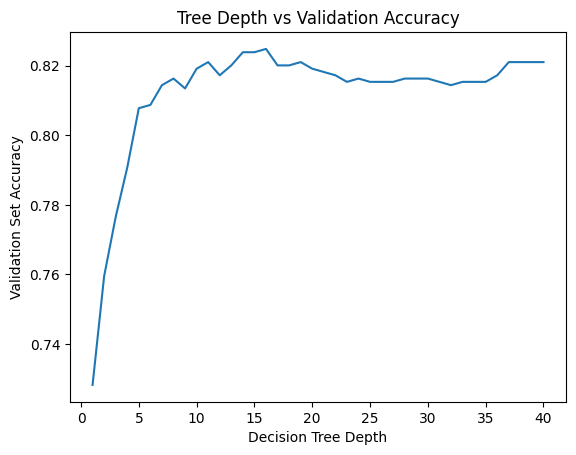

In [65]:
#here we want to make a plot of the validation accuracies for trees of differing
#depths and we do so as dollows
import matplotlib.pyplot as plt
depth_vals = np.arange(1, 41)
valacc = []
for depth in depth_vals:
  dt_s = DecisionTree(depth, features)
  dt_s.fit(spam_training_data, spam_training_labels)
  dtspred = dt_s.predict(spam_validation_data)
  valacc.append(sklearn.metrics.accuracy_score(spam_validation_labels, dtspred))
plt.plot(depth_vals, valacc)
plt.xlabel("Decision Tree Depth")
plt.ylabel("Validation Set Accuracy")
plt.title("Tree Depth vs Validation Accuracy")


In [66]:
#to set up the titanic data we just use what we had in the starter code:

path_train = 'hw5_code/dataset/titanic/titanic_training.csv'
data = genfromtxt(path_train, delimiter=',', dtype=None, encoding=None)
path_test = 'hw5_code/dataset/titanic/titanic_test_data.csv'
test_data = genfromtxt(path_test, delimiter=',', dtype=None, encoding=None)
y = data[1:, -1]  # label = survived
class_names = ["Died", "Survived"]
labeled_idx = np.where(y != '')[0]
y = np.array(y[labeled_idx])
y = y.astype(float).astype(int)
print("\n\nPart (b): preprocessing the titanic dataset")
X, onehot_features = preprocess(data[1:, :-1], onehot_cols=[1, 5, 7, 8])
X = X[labeled_idx, :]
Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
assert X.shape[1] == Z.shape[1]
features = list(data[0, :-1]) + onehot_features


#here we do the same thing we did with the spam data where we randomly shuffle
#the data and we will then reassign the data accordingy:
titanic_r = sk.utils.shuffle(X, y, random_state=0)
spl=round(.2 * X.shape[0])
titanic_t_data = titanic_r[0]
titanic_t_labels = titanic_r[1]
titanic_training_data = titanic_t_data[spl:]
titanic_training_labels = titanic_t_labels[spl:]
titanic_validation_data = titanic_t_data[:spl]
titanic_validation_labels = titanic_t_labels[:spl]

#here we set up the titanic decision tree and random forest then we get the errors
#for it and we do so after we do everything we need to do for the spam data
dt_t = DecisionTree(10, features)
dt_t.fit(titanic_training_data, titanic_training_labels)
dt_t_trainingpred = dt_t.predict(titanic_training_data)
dt_t_validationpred = dt_t.predict(titanic_validation_data)
rf_t = RandomForest(10, features, 2000, 3, 80)
rf_t.fit(titanic_training_data, titanic_training_labels)
rf_t_trainingpred = rf_t.predict(titanic_training_data)
rf_t_validationpred = rf_t.predict(titanic_validation_data)

print("Decision Tree Training Error: ", sklearn.metrics.accuracy_score(titanic_training_labels, dt_t_trainingpred))
print("Decision Tree Validation Error: ", sklearn.metrics.accuracy_score(titanic_validation_labels, dt_t_validationpred))
print("Random Forest Training Error: ", sklearn.metrics.accuracy_score(titanic_training_labels, rf_t_trainingpred))
print("Random Forest Validation Error: ", sklearn.metrics.accuracy_score(titanic_validation_labels, rf_t_validationpred))






Part (b): preprocessing the titanic dataset


<ipython-input-62-a2668c47e886>:283: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(data[((data[:, i] < -1 - eps) +
<ipython-input-62-a2668c47e886>:95: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.pred = stats.mode(y).mode[0]
<ipython-input-

Decision Tree Training Error:  0.8973717146433041
Decision Tree Validation Error:  0.735
Random Forest Training Error:  0.8297872340425532
Random Forest Validation Error:  0.78


In [70]:
#we are told to do depth 3 decision trees
dt_t_2 = DecisionTree(3, features)
dt_t_2.fit(titanic_training_data, titanic_training_labels)

class_names=["Died","Survived"]

#here we create a new function in order to create
#our shallow decision tree:
def display_dt(node, d):
  #the space here is to make sure that we can easily see the decision
  #tree broken down
  msg = "            " * d 
  #here we check if the node has a class yet, such as 
  #survived or died and if it is we stop, else we keep
  #going
  if not node.pred is None:
    print(msg + class_names[node.pred])
  else:
    #here we will basically do one decision tree side all the way
    #and then we move on to the next decision tree
    msg += node.features[node.split_idx]
    print(msg + " < " + str(node.thresh))
    display_dt(node.left, d + 1)
    print(msg + " >= " + str(node.thresh))
    display_dt(node.right, d + 1)

display_dt(dt_t_2, 0)

male < 1e-05
            pclass < 2.11111
                        S < 1e-05
                                    Survived
                        S >= 1e-05
                                    Survived
            pclass >= 2.11111
                        S < 1e-05
                                    Survived
                        S >= 1e-05
                                    Died
male >= 1e-05
            C < 1e-05
                        pclass < 1.00001
                                    Died
                        pclass >= 1.00001
                                    Died
            C >= 1e-05
                        age < -0.99999
                                    Died
                        age >= -0.99999
                                    Died


<ipython-input-62-a2668c47e886>:98: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.pred = stats.mode(y).mode[0]


In [71]:
#After doing all this we want to make our kaggle submission
#and we define the results to csv function as we have done 
#before in previous assignments:
import pandas as pd
def results_to_csv(pred, name):
  csvconv = pd.DataFrame({'Category': pred})
  csvconv.index += 1
  csvconv.to_csv(name, index_label='Id')

results_to_csv(rf_s.predict(spam_test).astype(int),'testspam.csv')
results_to_csv(rf_t.predict(Z).astype(int),'testtitanic.csv')



<ipython-input-62-a2668c47e886>:242: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  allpreds.append(stats.mode(curr_p[elt])[0][0])
